In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.graph_objs as go

from ostk.physics.units import Length
from ostk.physics.units import Angle
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.time import DateTime
from ostk.physics.coordinate import Frame
from ostk.physics import Environment
from ostk.physics.environment.objects.celestial_bodies import Earth

from ostk.astrodynamics import Trajectory
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory.orbit.models import Kepler
from ostk.astrodynamics.trajectory.orbit.models.kepler import COE

from utils import propagator, convertState, convertStateLLA
from models import keplerianDynamics, keplerianJacobian

%load_ext autoreload
%autoreload 2

/srv/conda/envs/notebook/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for ostk::physics::time::DateTime already registered; second conversion method ignored.

/srv/conda/envs/notebook/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for ostk::math::obj::IntervalBase::Type already registered; second conversion method ignored.



In [2]:
environment = Environment.default()

In [3]:
epoch = Instant.date_time(DateTime(2020, 1, 1, 0, 0, 0), Scale.UTC)
earth = environment.access_celestial_object_with_name("Earth")

start_instant = Instant.date_time(DateTime(2020, 1, 1, 0, 0, 0), Scale.UTC)
end_instant   = Instant.date_time(DateTime(2020, 1, 1, 1, 0, 0), Scale.UTC)
interval = Interval.closed(start_instant, end_instant)
step = Duration.minutes(1.0)
instants = interval.generate_grid(step)

In [4]:
G = {}

a0 = Length.kilometers(7000.0)
e0 = 0.0001
i0 = Angle.degrees(35.0)
raan0 = Angle.degrees(40.0)
aop0 = Angle.degrees(45.0)
nu0 = Angle.degrees(50.0)
G['0'] = [a0, e0, i0, raan0, aop0, nu0]

#Satellite GPS1
a1 = Length.kilometers(26559.8)
e1 = 10**-7
i1 = Angle.degrees(55.0)
raan1 = Angle.degrees(48.85)
aop1 = Angle.degrees(0.0)
nu1 = Angle.degrees(83.29)
G['1'] = [a1, e1, i1, raan1, aop1, nu1]

#Satellite GPS2
a2 = Length.kilometers(26559.8)
e2 = 10**-7
i2 = Angle.degrees(55.0)
raan2 = Angle.degrees(48.85)
aop2 = Angle.degrees(0.0)
nu2 = Angle.degrees(343.21)
G['2'] = [a2, e2, i2, raan2, aop2, nu2]

#Satellite GPS3
a3 = Length.kilometers(26559.8)
e3 = 10**-7
i3 = Angle.degrees(55.0)
raan3 = Angle.degrees(48.85)
aop3 = Angle.degrees(0.0)
nu3 = Angle.degrees(311.08)
G['3'] = [a3, e3, i3, raan3, aop3, nu3]

#Satellite GPS4
a4 = Length.kilometers(26559.8)
e4 = 10**-7
i4 = Angle.degrees(55.0)
raan4 = Angle.degrees(48.85)
aop4 = Angle.degrees(0.0)
nu4 = Angle.degrees(212.97)
G['4'] = [a4, e4, i4, raan4, aop4, nu4]

n = len(G)
num_gps = n-1

def orbit_gen(G, k):
    a, e, i, raan, aop, nu = G[str(k)]
    coe = COE(a, e, i, raan, aop, nu)
    model = Kepler(coe, epoch, earth, Kepler.PerturbationType.No)
    orbit = Orbit(model, earth)
    
    states = np.array([[convertState(orbit.get_state_at(instant))] for instant in instants])
    
    states_ints = [[instant, orbit.get_state_at(instant)] for instant in instants]
    orbit_data = [convertStateLLA(instant, state) for [instant, state] in states_ints]
    orbit_data = np.array(orbit_data)
    orbit_df = pd.DataFrame(orbit_data, columns= \
    ['$Time^{UTC}$', '$MJD^{UTC}$', '$x_{x}^{ECI}$', '$x_{y}^{ECI}$', '$x_{z}^{ECI}$', '$v_{x}^{ECI}$', '$v_{y}^{ECI}$', '$v_{z}^{ECI}$', '$Latitude$', '$Longitude$', '$Altitude$'])
    return states, orbit, orbit_df

states = np.zeros((num_gps, 6, len(instants)))
orbit = []
for i in range(1,n):
    states_i, orbit_i, _ = orbit_gen(G, i)
    states[i-1, :,  :] = np.squeeze(np.array(states_i)).T
    orbit.append(orbit_i)
print(states.shape)

(4, 6, 61)


In [5]:
orbit_df = {}

for i in range(n):
    orbit_df[str(i)] = orbit_gen(G, i)

In [ ]:
figure = go.Figure()

for i in range(n):
    
    _, _, orbit_sat = orbit_df[str(i)]
    color = 'blue'
    
    if i == 0:
        color = 'red'
    
    figure.add_trace(go.Scattergeo(
            lon = orbit_sat['$Longitude$'],
            lat = orbit_sat['$Latitude$'],
            mode = 'lines',
            line = go.scattergeo.Line(
                width = 1,
                color = color
            )
        ))

figure.update_layout(
        title = None,
        showlegend = False,
        height=1000,
        geo = go.layout.Geo(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)'
        )
    )

figure.show()

In [6]:
from measurement import generateMeasurements, measurements, measJacobian
from filters import EKF, UKF, PF, UPF

In [7]:
X0 = np.array(convertState(orbit[0].get_state_at(instants[0])))
dt = step.in_seconds()

X_kepler = np.zeros((len(instants), 6))
X_kepler[0,:] = X0
for t in range(1,len(instants)):
    X_kepler[t,:] = propagator(X_kepler[t-1,:], dt, keplerianDynamics)
    
# Covariance of process noise
Q = np.diag([1000, 1000, 1000, 10, 10, 10])

# Covariance of measurement noise
R = 1000 * np.eye(16)

# Process noise
X_kepler_noisy = X_kepler + np.random.multivariate_normal(np.zeros(6),Q,len(instants))

# Generate noisy measurements
Y_kepler = generateMeasurements(states, X_kepler_noisy, R, noise=True)

# Initial mean and covariance
mu0 = X0
Sigma0 = np.diag([1000, 1000, 1000, 10, 10, 10])

/home/jovyan/utils.py:12: RuntimeWarning:

overflow encountered in multiply



In [10]:
mu, _ = EKF(X=X_kepler_noisy, Y=Y_kepler,
            mu0=mu0, Sigma0=Sigma0,
            Q=Q, R=R,
            fDynamics=keplerianDynamics,
            fMeas=measurements,
            JDynamics=keplerianJacobian,
            JMeas = measJacobian,
            X_gps = states, 
            propagator=propagator,
            dt=dt
           )

mu_UKF, _ = UKF(X=X_kepler_noisy, Y=Y_kepler,
            mu0=mu0, Sigma0=Sigma0,
            Q=Q, R=R,
            fDynamics=keplerianDynamics,
            fMeas=measurements,
            X_gps = states, 
            propagator=propagator,
            dt=dt
           )

N = 100
mu_PF = PF(X=X_kepler_noisy, Y=Y_kepler, 
        mu0=mu0, Sigma0=Sigma0,
        Q=Q, R=R, N=N,
        fDynamics=keplerianDynamics,
        fMeas=measurements,
        propagator=propagator,
        dt=dt,
        X_gps=states
       )

N = 10
mu_UPF = UPF(X=X_kepler_noisy, Y=Y_kepler, 
        mu0=mu0, Sigma0=Sigma0,
        Q=Q, R=R, N=N,
        fDynamics=keplerianDynamics,
        fMeas=measurements,
        propagator=propagator,
        dt=dt,
        X_gps=states
       )

/home/jovyan/utils.py:12: RuntimeWarning:

overflow encountered in multiply



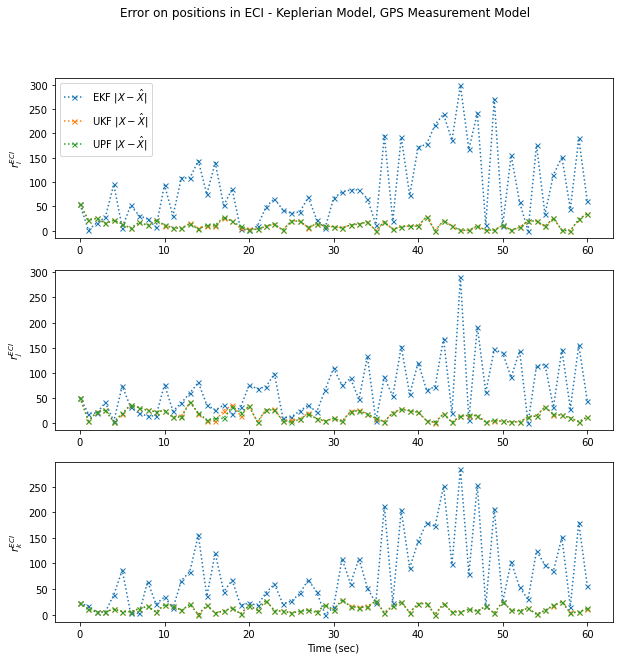

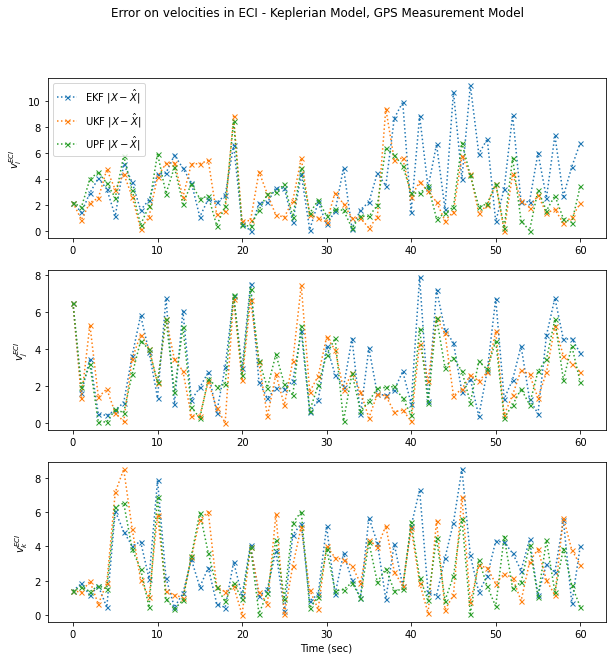

In [13]:
plot_PF = False
plot_UPF = True

fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Error on positions in ECI - Keplerian Model, GPS Measurement Model')
axs[0].plot(abs(X_kepler_noisy[:,0]-mu[:,0]), ':x', ms=5, label="EKF $|X-\hat{X}|$")
axs[0].plot(abs(X_kepler_noisy[:,0]-mu_UKF[:,0]), ':x', ms=5, label="UKF $|X-\hat{X}|$")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[1].plot(abs(X_kepler_noisy[:,1]-mu[:,1]), ':x', ms=5)
axs[1].plot(abs(X_kepler_noisy[:,1]-mu_UKF[:,1]), ':x', ms=5)
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(abs(X_kepler_noisy[:,2]-mu[:,2]), ':x', ms=5)
axs[2].plot(abs(X_kepler_noisy[:,2]-mu_UKF[:,2]), ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$r_k^{ECI}$")
if plot_PF:
    axs[0].plot(abs(X_kepler_noisy[:,0]-mu_PF[:,0]), ':x', ms=5, label="  PF $|X-\hat{X}|$")
    axs[1].plot(abs(X_kepler_noisy[:,1]-mu_PF[:,1]), ':x', ms=5)
    axs[2].plot(abs(X_kepler_noisy[:,2]-mu_PF[:,2]), ':x', ms=5)
if plot_UPF:
    axs[0].plot(abs(X_kepler_noisy[:,0]-mu_UPF[:,0]), ':x', ms=5, label="UPF $|X-\hat{X}|$")
    axs[1].plot(abs(X_kepler_noisy[:,1]-mu_UPF[:,1]), ':x', ms=5)
    axs[2].plot(abs(X_kepler_noisy[:,2]-mu_UPF[:,2]), ':x', ms=5)
axs[0].legend(loc="upper left")
    
fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Error on velocities in ECI - Keplerian Model, GPS Measurement Model')
axs[0].plot(abs(X_kepler_noisy[:,3]-mu[:,3]), ':x', ms=5, label="EKF $|X-\hat{X}|$")
axs[0].plot(abs(X_kepler_noisy[:,3]-mu_UKF[:,3]), ':x', ms=5, label="UKF $|X-\hat{X}|$")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[1].plot(abs(X_kepler_noisy[:,4]-mu[:,4]), ':x', ms=5)
axs[1].plot(abs(X_kepler_noisy[:,4]-mu_UKF[:,4]), ':x', ms=5)
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(abs(X_kepler_noisy[:,5]-mu[:,5]), ':x', ms=5)
axs[2].plot(abs(X_kepler_noisy[:,5]-mu_UKF[:,5]), ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$v_k^{ECI}$")
if plot_PF:
    axs[0].plot(abs(X_kepler_noisy[:,3]-mu_PF[:,3]), ':x', ms=5, label="  PF $|X-\hat{X}|$")
    axs[1].plot(abs(X_kepler_noisy[:,4]-mu_PF[:,4]), ':x', ms=5)
    axs[2].plot(abs(X_kepler_noisy[:,5]-mu_PF[:,5]), ':x', ms=5)
if plot_UPF:
    axs[0].plot(abs(X_kepler_noisy[:,3]-mu_UPF[:,3]), ':x', ms=5, label="UPF $|X-\hat{X}|$")
    axs[1].plot(abs(X_kepler_noisy[:,4]-mu_UPF[:,4]), ':x', ms=5)
    axs[2].plot(abs(X_kepler_noisy[:,5]-mu_UPF[:,5]), ':x', ms=5)
axs[0].legend(loc="upper left")